# Entregable Nro. 1: Análisis y Visualización de Sitios Web para Detección de Fraudes

Este notebook contiene la resolución correspondiente al primer trabajo: análisis exploratorio de datos, para el proyecto "El Robo del Siglo → Digital", enfocado en la detección de sitios web fraudulentos.

**Grupo 1:** Manuel Lopez Werlen - Ayelen Margarita Bertorello - Silvio Fabian Marasca - Ignacio Ariel Lopez Parra

Para comenzar realizamos las siguientes aclaraciones: Como equipo/grupo decidimos trabajar con el archivo compartido desde la mentora, para realizar nuestra versión lo modificamos e intervenimos la notebook, en base a las siguientes tareas:
1. Configuración del Entorno y Generar un dataset desde el sitio web: Tranco List
2. Procesamiento del dataset
3. Análisis de forma exploratoria del dataset (EDA)
4. Scraping general
5. Visualización los datos
6. Identificación de datos sospechosos
7. Generación de datos sintéticos
8. Conclusiones y pasos a futuro
8. Generación de un dataset "Final"

#1. Configuración del Entorno y Generar un dataset desde el sitio web: Tranco-List

In [ ]:
!pip install requests pandas fake_useragent tldextract python-whois Faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import requests
import tldextract
import whois
import random
import re
from fake_useragent import UserAgent
from faker import Faker
from datetime import datetime
from tqdm.notebook import tqdm
from urllib.parse import urlparse
import time
import ssl
import socket
import warnings
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

fake = Faker('es_AR')
ua = UserAgent()

tqdm.pandas()

Generar un dataset desde el sitio web Tranco-List

In [ ]:
# Descargamos el top millon de sitios desde Tranco-List
url = "https://tranco-list.eu/download/X456N/1000000"
df = pd.read_csv(url, header=None, names=["rank", "domain"])
# Filtramos para quedarnos solo con los sitios argentinos
df_ar = df[df["domain"].str.endswith(".ar")].reset_index(drop=True)

#2. Procesamiento del dataset

In [ ]:
# Definimos una función para categorizar los dominios
def clasificar_categoria(dominio):
    """
    Clasifica un dominio web en una categoría temática general según palabras clave presentes.

    Esta función busca términos genéricos en el nombre del dominio para asignarle una categoría
    temática amplia como "noticias", "gobierno", "banca", "e-commerce" o "educacion". Si no
    encuentra coincidencias, clasifica el dominio como "otro".

    Args:
        dominio (str): Nombre de dominio (por ejemplo, "noticiasargentinas.com.ar").

    Returns:
        str: Categoría general a la que pertenece el dominio. Puede ser:
            - "noticias"
            - "gobierno"
            - "banca"
            - "e-commerce"
            - "educacion"
            - "otro"
    """
    dominio = dominio.lower()

    if any(x in dominio for x in ["news", "noticia", "diario", "prensa", "periodico", "press"]):
        return "noticias"
    elif any(x in dominio for x in ["gob", "gov", "municipio", "ministerio", "provincia", ".gob.", ".gov."]):
        return "gobierno"
    elif any(x in dominio for x in ["banco", "bank", "finance", "finanzas", "credito", "loan", "tarjeta"]):
        return "banca"
    elif any(x in dominio for x in ["shop", "store", "tienda", "ecommerce", "comprar", "venta", "oferta"]):
        return "e-commerce"
    elif any(x in dominio for x in ["edu", "universidad", "facultad", "campus", "colegio", "escuela", "instituto"]):
        return "educacion"
    else:
        return "otro"

In [ ]:
def procesar_dominio_basico(dominio: str) -> dict:
    """
    Procesa información básica y rápida sobre un dominio.

    Extrae métricas estáticas y consulta WHOIS sin realizar scraping ni peticiones HTTP pesadas.

    Args:
        dominio (str): Nombre de dominio (ej. "example.com").

    Returns:
        dict: Diccionario con información sobre el dominio que incluye:
            - url (str): URL base construida (http).
            - longitud_url (int): Longitud total de la URL.
            - cantidad_guiones (int): Cantidad de guiones en el dominio.
            - cantidad_digitos (int): Cantidad de dígitos en el dominio.
            - caracteres_especiales (int): Cantidad de caracteres especiales en la URL.
            - segmentos_path (int): Número de segmentos en el path (usualmente 0).
            - tld (str): Dominio de nivel superior.
            - tiempo_registro (float): Años desde creación según WHOIS.
            - fecha_creacion (str|None): Fecha de creación en formato ISO o None.
            - fecha_expiracion (str|None): Fecha de expiración en formato ISO o None.
            - registrador (str|None): Registrador WHOIS o None.
            - pais_registro (str|None): País de registro WHOIS o None.
            - es_phishing (None): Campo reservado para futuro uso.
    """
    headers = {'User-Agent': ua.random}
    url = f"http://{dominio}"

    longitud_url = len(url)
    cantidad_guiones = dominio.count('-')
    cantidad_digitos = sum(c.isdigit() for c in dominio)
    caracteres_especiales = len(re.findall(r'[^\w\s:/.-]', dominio))
    segmentos_path = len(urlparse(url).path.strip('/').split('/')) if urlparse(url).path else 0

    ext = tldextract.extract(dominio)
    dominio_registrado = f"{ext.domain}.{ext.suffix}"
    tld = ext.suffix

    # WHOIS
    tiempo_registro = 0
    registrador = None
    pais_registro = None
    fecha_creacion = None
    fecha_expiracion = None

    try:
        info_whois = whois.whois(dominio_registrado)
        creation_date = info_whois.creation_date[0] if isinstance(info_whois.creation_date, list) else info_whois.creation_date
        expiration_date = info_whois.expiration_date[0] if isinstance(info_whois.expiration_date, list) else info_whois.expiration_date

        fecha_creacion = creation_date.isoformat() if creation_date else None
        fecha_expiracion = expiration_date.isoformat() if expiration_date else None
        tiempo_registro = (datetime.now() - creation_date).days / 365 if creation_date else 0

        registrador = info_whois.registrar
        pais_registro = info_whois.get("country") or info_whois.get("registrant_country") or "Desconocido"
    except:
        pass

    return {
        "url": url,
        "longitud_url": longitud_url,
        "cantidad_guiones": cantidad_guiones,
        "cantidad_digitos": cantidad_digitos,
        "caracteres_especiales": caracteres_especiales,
        "segmentos_path": segmentos_path,
        "tld": tld,
        "tiempo_registro": tiempo_registro,
        "fecha_creacion": fecha_creacion,
        "fecha_expiracion": fecha_expiracion,
        "registrador": registrador,
        "pais_registro": pais_registro,
        "es_phishing": None
    }

In [ ]:
# Limitar (por ahora) a los primeros 100 para evitar bloqueos
subset = df_ar.head(100)

# Obtener Datos
results = []
for row in tqdm(subset.itertuples(index=False), total=len(subset), desc="Procesando dominios"):
    info = procesar_dominio_basico(row.domain)
    info["es_phishing"] = False  # Agregar la columna con valor True
    results.append(info)
    time.sleep(1)

# Guardar CSV
df_procesado = pd.DataFrame(results)
df_procesado.to_csv("sitios_argentinos_procesados.csv", index=False)
print("✅ CSV enriquecido guardado como sitios_argentinos_procesados.csv")

Procesando dominios:   0%|          | 0/100 [00:00<?, ?it/s]

✅ CSV enriquecido guardado como sitios_argentinos_procesados.csv


**Función para obtener lista de sitios fraudulentos.**

Decidimos nutrirnos de: OpenPhish un servicio que ofrece una lista pública y actualizada de sitios web de phishing.
Este sitio es automático, actualizado y gratuito, proporciona casos reales en circulación y nos ayuda a no depender solo de sitios simulados para estudiar fraudes digitales.



In [ ]:
# URL del feed de OpenPhish (gratuito, sin autenticación)

url_feed = "https://openphish.com/feed.txt"

# Descargar el contenido del feed
response = requests.get(url_feed)

# Verificar si la descarga fue exitosa
if response.status_code == 200:
    urls = response.text.strip().split('\n')

    # Crear DataFrame
    df_phishing = pd.DataFrame(urls, columns=["url"])

    # Guardar como CSV
    df_phishing.to_csv("sitios_fraudulentos.csv", index=False)
    print("✅ Archivo guardado como 'sitios_fraudulentos.csv'")
else:
    print(f"❌ Error al descargar el feed: código {response.status_code}")


✅ Archivo guardado como 'sitios_fraudulentos.csv'


#3. Análisis de forma exploratoria del dataset (EDA)

In [ ]:
# Estadísticas descriptivas de variables
print("Estadísticas descriptivas de variables numéricas:")
numeric_stats = df_procesado.describe(include=[np.number])
numeric_stats

Estadísticas descriptivas de variables numéricas:


,longitud_url,cantidad_guiones,cantidad_digitos,caracteres_especiales,segmentos_path,tiempo_registro
count,100.000000,100.0,100.000000,100.0,100.0,100.000000
mean,20.800000,0.0,0.090000,0.0,0.0,5.182959
std,3.428932,0.0,0.533617,0.0,0.0,5.879649
min,13.000000,0.0,0.000000,0.0,0.0,0.000000
25%,18.000000,0.0,0.000000,0.0,0.0,0.000000
50%,21.000000,0.0,0.000000,0.0,0.0,0.000000
75%,23.000000,0.0,0.000000,0.0,0.0,11.719178
max,31.000000,0.0,4.000000,0.0,0.0,12.504110


In [ ]:
# Estadísticas de variables categóricas
print("\nEstadísticas de variables categóricas:")
categorical_stats = df_procesado.describe(include=['object'])
categorical_stats


Estadísticas de variables categóricas:


,url,tld,fecha_creacion,fecha_expiracion,registrador,pais_registro
count,100,100,44,44,44,78
unique,100,8,30,32,1,1
top,http://mercadolibre.com.ar,com.ar,2013-08-22T00:00:00,2026-01-01T00:00:00,nicar,Desconocido
freq,1,58,5,5,44,78


In [ ]:
# Verificar valores nulos
print("Valores nulos por columna:")
null_counts = df_procesado.isnull().sum()
null_counts

Valores nulos por columna:


,0
url,0
longitud_url,0
cantidad_guiones,0
cantidad_digitos,0
caracteres_especiales,0
segmentos_path,0
tld,0
tiempo_registro,0
fecha_creacion,56
fecha_expiracion,56


#4. Scraping general

En esta sección vamos a implementar un proceso de web scraping básico sobre los dominios recopilados, con el objetivo de obtener información dinámica directamente desde los sitios web. Esta información permite enriquecer el dataset con características que no están disponibles mediante fuentes estáticas, y aporta contexto sobre el comportamiento real de los sitios analizados.

In [ ]:
def enriquecer_dominio_scraping(dominio: str) -> dict:
    """
    Realiza scraping para obtener información dinámica y pesada de un dominio.

    Ejecuta peticiones HTTP (HTTPS primero, luego HTTP) para obtener el título,
    tiempo de respuesta, código de estado y URL redireccionada.

    Args:
        dominio (str): Nombre de dominio (ej. "example.com").

    Returns:
        dict: Diccionario con datos de scraping que incluye:
            - titulo (str): Texto del título HTML (o cadena vacía).
            - categoria (str): Categoría del dominio según palabras clave.
            - tiene_https (bool): Siempre False (no se prueba HTTPS aquí).
            - tiene_ssl (bool): Siempre False (no se verifica aquí).
            - tiempo_respuesta (float): Tiempo en segundos de la petición.
            - responde (bool): Indica si el sitio respondió.
            - codigo_estado (int): Código HTTP de respuesta.
            - url_redireccionada (str): URL final tras redirecciones.
            - longitud_titulo (int): Largo del título en caracteres.
            - palabras_clave (int): Cantidad de palabras en el título.
    """

    esquemas = ["https", "http"]
    titulo = ""
    tiempo_respuesta = 0
    responde = False
    codigo_estado = 0
    url_redireccionada = ""
    tiene_https = False

    for esquema in esquemas:
        try:
            url = f"{esquema}://{dominio}"
            inicio = time.time()
            r = requests.get(url, timeout=5, allow_redirects=True)
            fin = time.time()

            tiempo_respuesta = round(fin - inicio, 3)
            responde = True
            codigo_estado = r.status_code
            url_redireccionada = r.url

            soup = BeautifulSoup(r.text, "html.parser")
            titulo_tag = soup.find("title")
            if titulo_tag:
                titulo = titulo_tag.text.strip()
            if esquema == "https":
                tiene_https = True
            break
        except:
            continue

    longitud_titulo = len(titulo)
    palabras_clave = len(re.findall(r'\b\w+\b', titulo))

    # SSL check (solo si asumimos https para alguna heurística)
    tiene_ssl = False
    if tiene_https:
        try:
            hostname = urlparse(url).hostname
            context = ssl.create_default_context()
            with socket.create_connection((hostname, 443), timeout=5) as sock:
                with context.wrap_socket(sock, server_hostname=hostname) as ssock:
                    tiene_ssl = bool(ssock.getpeercert())
        except:
            pass

    categoria = clasificar_categoria(titulo)

    return {
        "titulo": titulo,
        "categoria": categoria,
        "tiene_https": tiene_https,
        "tiene_ssl": tiene_ssl,
        "tiempo_respuesta": tiempo_respuesta,
        "responde": responde,
        "codigo_estado": codigo_estado,
        "url_redireccionada": url_redireccionada,
        "longitud_titulo": longitud_titulo,
        "palabras_clave": palabras_clave
    }


In [ ]:
# Lista para almacenar los nuevos datos
datos_scraping = []

for row in tqdm(df_procesado.itertuples(index=False), total=len(df_procesado), desc="Enriqueciendo con scraping"):
    dominio = row.url.replace("http://", "").replace("https://", "").split("/")[0]
    scraping_info = enriquecer_dominio_scraping(dominio)
    datos_scraping.append(scraping_info)
    time.sleep(1)

# Convertir la lista en DataFrame
df_scraping = pd.DataFrame(datos_scraping)

# Combinar con el DataFrame original
df_final = pd.concat([df_procesado.reset_index(drop=True), df_scraping], axis=1)

# Guardar CSV enriquecido
df_final.to_csv("sitios_argentinos_enriquecidos.csv", index=False)
print("✅ CSV enriquecido guardado como sitios_argentinos_enriquecidos.csv")

Enriqueciendo con scraping:   0%|          | 0/100 [00:00<?, ?it/s]

✅ CSV enriquecido guardado como sitios_argentinos_enriquecidos.csv


#5. Visualización de datos

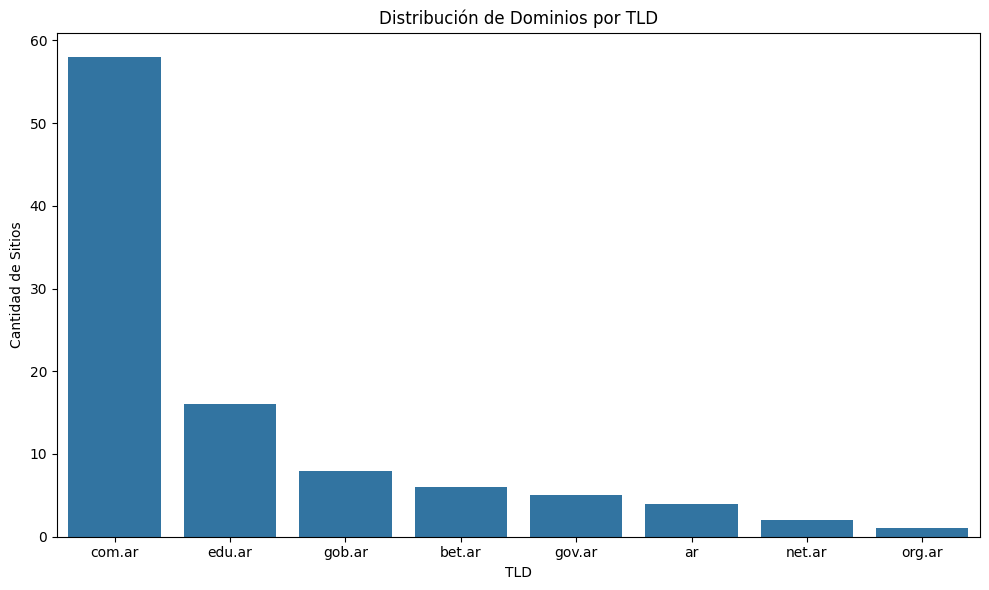

In [ ]:
# Distribución de TLDs
plt.figure(figsize=(10, 6))
tld_counts = df_final['tld'].value_counts()
sns.barplot(x=tld_counts.index, y=tld_counts.values)
plt.title('Distribución de Dominios por TLD')
plt.xlabel('TLD')
plt.ylabel('Cantidad de Sitios')
plt.tight_layout()
plt.show()

_De los sitios observados, solo el 18% presenta TLD diferentes de .com.ar, edu.ar o gob.ar. Estos sitios presentan mas posibilidades de ser phising y deberían ser analizados en mayor profundidad_

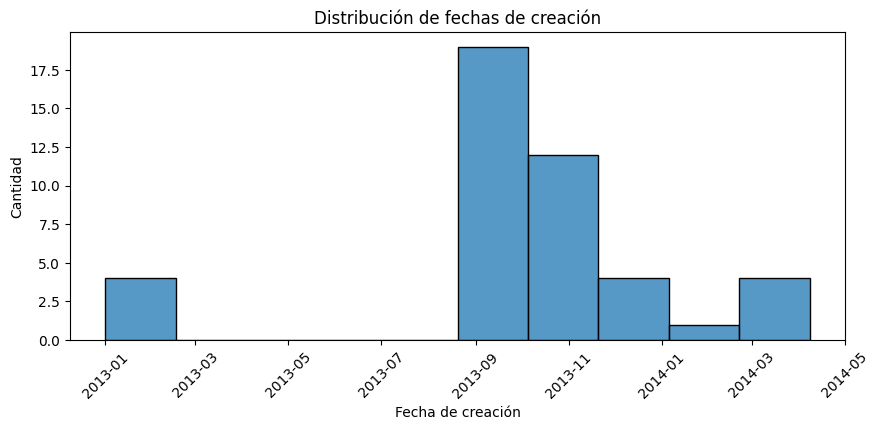

In [ ]:
# Histograma fecha de creación
df_final['fecha_creacion'] = pd.to_datetime(df_final['fecha_creacion'], errors='coerce')
plt.figure(figsize=(10, 4))
sns.histplot(df_final['fecha_creacion'].dropna(), bins=10, kde=False)
plt.title('Distribución de fechas de creación')
plt.xlabel('Fecha de creación')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

_La mayoría de los sitios analizados fueron creados entre septiembre y noviembre de 2013. Ninguno de los sitios top .ar fue creado en los últimos diez años, lo cual tiene sentido dada su legitimidad/popularidad._

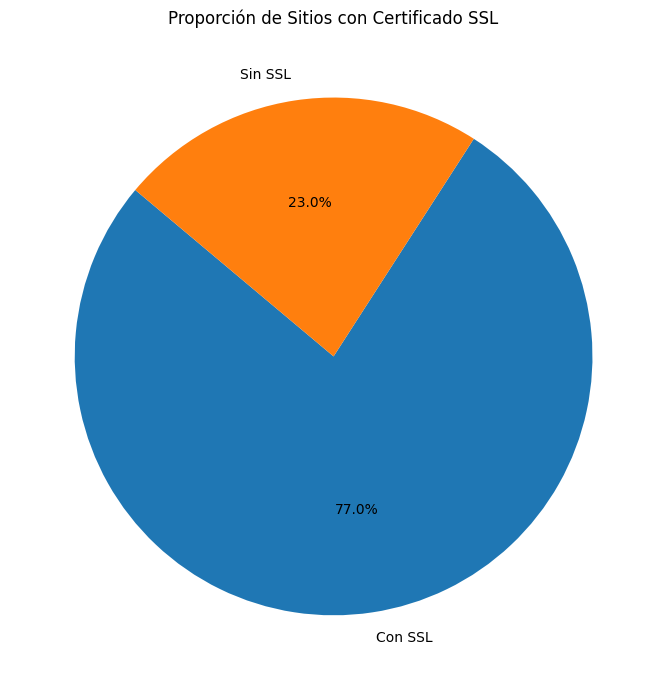

In [ ]:
# Proporción de variable tiene_ssl
ssl_counts = df_final['tiene_ssl'].value_counts()
labels = ['Con SSL' if val else 'Sin SSL' for val in ssl_counts.index]
plt.figure(figsize=(7, 7))
plt.pie(ssl_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporción de Sitios con Certificado SSL')
plt.tight_layout()
plt.show()

_Aquí podemos observar que casi el 80% de los sitios reales analizados utilizan SSL. Si bien el hecho de que no se use no es un indicador de que un sitio sea efectivamente de phising, su no utilización puede ser un indicador._

In [ ]:
# Información de las categorías agregadas
df_final["categoria"].value_counts()

,count
categoria,
otro,71
educacion,12
noticias,8
gobierno,5
banca,3
e-commerce,1


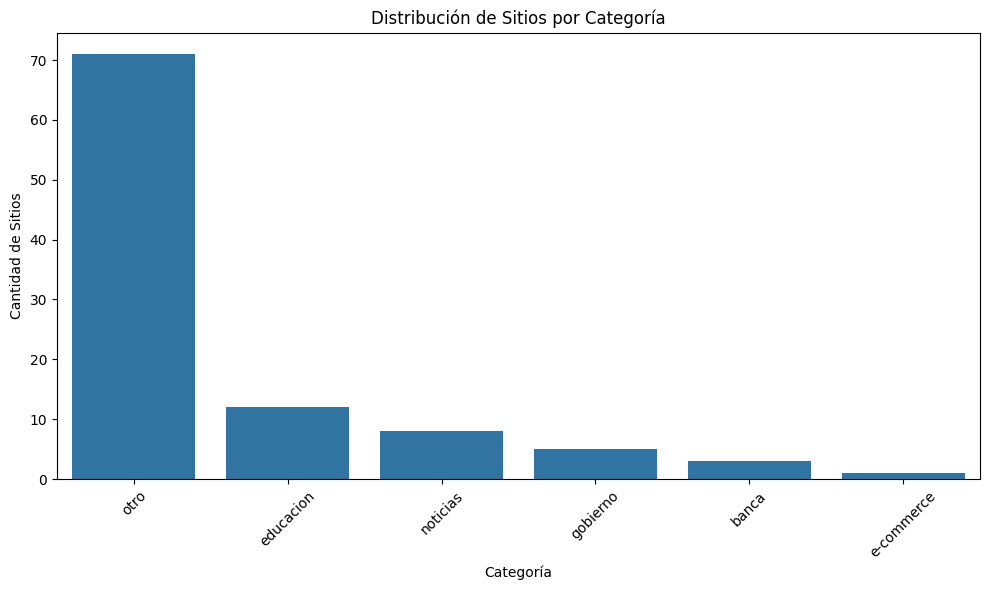

In [ ]:
# Distribución de sitios por categoría
plt.figure(figsize=(10, 6))
category_counts = df_final['categoria'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Distribución de Sitios por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Sitios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

_Se analizaron los dominios para categorizar los sitios. La búsqueda debe refinarse más pero es útil esta clasificación para poder determinar si los sitios son sospechosos o no._

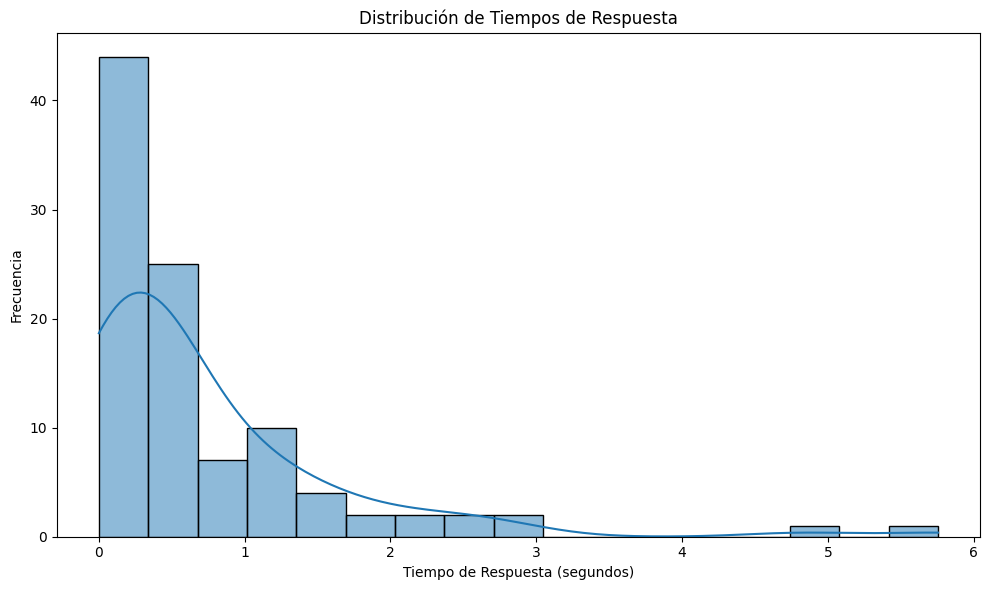

In [ ]:
# Distribución de tiempos de respuesta
plt.figure(figsize=(10, 6))
sns.histplot(df_final['tiempo_respuesta'], kde=True)
plt.title('Distribución de Tiempos de Respuesta')
plt.xlabel('Tiempo de Respuesta (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

_En este gráfico podemos ver que la mayoría de los sitios responde en tiempos  menores o iguales a un segundo, y un porcentaje muy bajo, por encima de los dos segundos. Un sitio con un tiempo de respuesta mayor, puede ser tenido en cuenta como sospechoso._

#6. Identificación de datos sospechosos

In [ ]:
# Dominios recientes (creados hace menos de 1 año)
dominios_recientes = df_final[(df_final['tiempo_registro'] > 0) & (df_final['tiempo_registro'] < 1)]
total_dominios = len(df_final)
cantidad_recientes = len(dominios_recientes)
porcentaje = (cantidad_recientes / total_dominios) * 100
print(f"Dominios con tiempo de registro menor a 1 año: {porcentaje:.2f}% ({cantidad_recientes} de {total_dominios})")

Dominios con tiempo de registro menor a 1 año: 0.00% (0 de 100)


In [ ]:
# URLs sospechosas por alto número de guiones o caracteres especiales
urls_sospechosas = df_final[(df_final['cantidad_guiones'] > 3) | (df_final['caracteres_especiales'] > 3)]
total_dominios = len(df_final)
cantidad_sospechosas = len(urls_sospechosas)
porcentaje = (cantidad_sospechosas / total_dominios) * 100
print(f"URLs con alta cantidad de guiones o caracteres especiales: {porcentaje:.2f}% ({cantidad_sospechosas} de {total_dominios})")

URLs con alta cantidad de guiones o caracteres especiales: 0.00% (0 de 100)


In [ ]:
# TLDs inusuales (no son .com.ar, .edu.ar o .gob.ar)
tlds_inusuales = df_final[~df_final['tld'].isin(['com.ar', 'edu.ar', 'gob.ar'])]
total_dominios = len(df_final)
cantidad_tld_inusual = len(tlds_inusuales)
porcentaje = (cantidad_tld_inusual / total_dominios) * 100
print(f"TLDs inusuales (distintos de .com.ar, .edu.ar o .gob.ar): {porcentaje:.2f}% ({cantidad_tld_inusual} de {total_dominios})")

TLDs inusuales (distintos de .com.ar, .edu.ar o .gob.ar): 18.00% (18 de 100)


In [ ]:
# Dominios sin certificado SSL
sin_ssl = df_final[df_final['tiene_ssl'] == False]
total_dominios = len(df_final)
cantidad_sin_ssl = len(sin_ssl)
porcentaje = (cantidad_sin_ssl / total_dominios) * 100
print(f"Dominios sin certificado SSL: {porcentaje:.2f}% ({cantidad_sin_ssl} de {total_dominios})")

Dominios sin certificado SSL: 23.00% (23 de 100)


In [ ]:
# Dominios con palabras clave sospechosas
palabras_sospechosas = [
    'banco', 'seguridad', 'actualización', 'verificación', 'urgente',
    'cuenta', 'tarjeta', 'débito', 'crédito', 'cbu', 'homebanking', 'transferencia',
    'validar', 'confirmación', 'clave', 'contraseña', 'acceso', 'autenticación', 'identidad',
    'importante', 'alerta','seguridad', 'aviso', 'inmediato', 'emergencia', 'notificación','ingresos', 'oficial',
    'regalo', 'sorteo', 'premio', 'ganaste', 'oferta', 'gratis', 'promoción', 'exclusivo',
    'ingresar', 'activar', 'acceder', 'desbloquear', 'iniciar sesión', 'confirmar'
]

# Función para detectar palabras en la URL
def contiene_palabra_sospechosa(texto):
    if pd.isna(texto):
        return False
    texto = texto.lower()
    return any(palabra in texto for palabra in palabras_sospechosas)

# Aplicar la función
urls_palabras_clave = df_final[df_final['url'].apply(contiene_palabra_sospechosa)]
total_dominios = len(df_final)
cantidad_con_palabras = len(urls_palabras_clave)
porcentaje = (cantidad_con_palabras / total_dominios) * 100
print(f"URLs con palabras clave sospechosas: {porcentaje:.2f}% ({cantidad_con_palabras} de {total_dominios})")

URLs con palabras clave sospechosas: 3.00% (3 de 100)


In [ ]:
# Buscar palabras clave sospechosas

# Función para contar coincidencias en el título
def analizar_texto_sospechoso(texto):
    if pd.isna(texto):
        return 0
    texto_lower = texto.lower()
    return sum(1 for palabra in palabras_sospechosas if palabra in texto_lower)

# Aplicar sin modificar el DataFrame
coincidencias = df_final['titulo'].apply(analizar_texto_sospechoso)
titulos_sospechosos = df_final[coincidencias > 0]

# Imprimir resumen
total_dominios = len(df_final)
cantidad_sospechosos = len(titulos_sospechosos)
porcentaje = (cantidad_sospechosos / total_dominios) * 100

print(f"Títulos con palabras clave sospechosas: {porcentaje:.2f}% ({cantidad_sospechosos} de {total_dominios})")

Títulos con palabras clave sospechosas: 6.00% (6 de 100)


Se aplicaron distintos criterios de detección sobre el subconjunto de 100 sitios reales para identificar posibles patrones asociados al comportamiento de sitios fraudulentos.
Si bien no se encontraron dominios con registro reciente ni URLs con estructuras sospechosas (guiones o caracteres especiales en exceso), sí se detectaron algunos indicios a tener en cuenta: un 18% presenta TLDs inusuales, el 22% carece de certificado SSL, y entre el 3% y el 6% de los sitios contienen palabras clave sospechosas tanto en la URL como en el título. Estos indicadores, si bien no implican necesariamente phishing, pueden ser señales de alerta en un análisis más amplio o en combinación con otros factores.

#7. Generación de datos sintéticos

In [ ]:
# Función para generar datos sinteticos
def generar_datos_sinteticos(n=100):
    datos_sinteticos = []

    for _ in range(n):
        sitio = fake.domain_name()
        titulo = fake.sentence(nb_words=random.randint(3, 10))
        tiempo_respuesta = round(random.uniform(0.1, 2.5), 3)
        responde = random.choice([True, False])
        codigo_estado = random.choice([200, 301, 302, 403, 404, 500])
        url_redireccionada = sitio if codigo_estado in [200, 403, 404, 500] else f"{sitio}/redirected"

        tld_info = tldextract.extract(sitio)
        tld = tld_info.suffix

        longitud_url = len(sitio)
        tiene_https = random.choice([True, False])
        tiene_ssl = tiene_https and random.choice([True, False])
        cantidad_guiones = sitio.count('-')
        cantidad_digitos = sum(c.isdigit() for c in sitio)
        caracteres_especiales = len(re.findall(r'[^\w\s:/.-]', sitio))
        segmentos_path = len(urlparse(sitio).path.strip('/').split('/')) if urlparse(sitio).path else 0
        longitud_titulo = len(titulo)
        palabras_clave = len(titulo.split())
        tiempo_registro = random.randint(1, 20)

        fecha_creacion = fake.date_between(start_date='-20y', end_date='-1y')
        fecha_expiracion = fake.date_between(start_date=fecha_creacion, end_date='+5y')

        registrador = fake.company()
        pais_registro = fake.country()

        categoria = clasificar_categoria(sitio)

        datos_sinteticos.append({
            "url": sitio,
            "titulo": titulo,
            "tiempo_respuesta": tiempo_respuesta,
            "responde": responde,
            "codigo_estado": codigo_estado,
            "url_redireccionada": url_redireccionada,
            "categoria": categoria,
            "longitud_url": longitud_url,
            "tiene_https": tiene_https,
            "tiene_ssl": tiene_ssl,
            "cantidad_guiones": cantidad_guiones,
            "cantidad_digitos": cantidad_digitos,
            "caracteres_especiales": caracteres_especiales,
            "segmentos_path": segmentos_path,
            "tld": tld,
            "longitud_titulo": longitud_titulo,
            "palabras_clave": palabras_clave,
            "tiempo_registro": tiempo_registro,
            "fecha_creacion": fecha_creacion.isoformat(),
            "fecha_expiracion": fecha_expiracion.isoformat(),
            "registrador": registrador,
            "pais_registro": pais_registro,
            "es_phishing": None
        })

    return pd.DataFrame(datos_sinteticos)


In [ ]:
df_sintetico = generar_datos_sinteticos(100)
df_sintetico.to_csv("sitios_argentinos_sinteticos.csv", index=False)
print("✅ CSV sintetico guardado como sitios_argentinos_sinteticos.csv")

✅ CSV sintetico guardado como sitios_argentinos_sinteticos.csv


#8. Conclusiones y pasos a futuro

En este trabajo se desarrolló un flujo completo para la recopilación y procesamiento de dominios web argentinos, enriqueciéndolo con el objetivo de generar un dataset estructurado útil para entrenar un modelo de clasificación supervisada. Se implementaron funciones eficientes para extraer características estáticas de los dominios (como longitud, cantidad de guiones, TLD, etc.) así como funciones de scraping más costosas para obtener información dinámica como tiempos de respuesta, redirecciones y títulos HTML.

Además, se generaron datos sintéticos simulando sitios legítimos y se obtuvieron datos de sitios de phishing reales. Se incluyó información WHOIS, como país de registro, registrador y fechas de creación y expiración del dominio. Finalmente, se unificaron todos los datos en un conjunto enriquecido y etiquetado, exportado a CSV para su posterior análisis.


In [ ]:
# Realizamos un resumen de lo anterior con ciertas aclaraciones que pensamos pueden ser útiles a futuro, como así también instrucciones de pasos a seguir.

print("Conclusiones:")
print("1. Se desarrolló un pipeline (un proceso automatizado y estructurado) completo para la recopilación, enriquecimiento y análisis de dominios web argentinos.")
print("2. La gran mayoría de los sitios argentinos analizados utilizan TLDs confiables como .com.ar, .edu.ar o .gob.ar.")
print("3. Los sitios que tiene mayor tiempo de respuesta puede ser tenidos en cuenta como fraude.")
print("4. La creacion del Dataset fue en base a 100 datos pero consideramos que para el siguimiento de este trabajo es necesario trabajar con todos los datos con los que contamos.")

print("\nPróximos Pasos (Entregable 2):")
print("1. Ampliar la recopilación de datos para incluir más sitios legítimos y fraudulentos.")
print("2. Realizar un análisis más profundo del contenido de los sitios, como así tambipen repensar nuevas categorías o subcategorías.")
print("3. Evaluar la implementación de técnicas de procesamiento de lenguaje natural para analizar el texto de los sitios.")

Conclusiones:
1. Se desarrolló un pipeline (un proceso automatizado y estructurado) completo para la recopilación, enriquecimiento y análisis de dominios web argentinos.
2. La gran mayoría de los sitios argentinos analizados utilizan TLDs confiables como .com.ar, .edu.ar o .gob.ar.
3. Los sitios que tiene mayor tiempo de respuesta puede ser tenidos en cuenta como fraude.
4. La creacion del Dataset fue en base a 100 datos pero consideramos que para el siguimiento de este trabajo es necesario trabajar con todos los datos con los que contamos.

Próximos Pasos (Entregable 2):
1. Ampliar la recopilación de datos para incluir más sitios legítimos y fraudulentos.
2. Realizar un análisis más profundo del contenido de los sitios, como así tambipen repensar nuevas categorías o subcategorías.
3. Evaluar la implementación de técnicas de procesamiento de lenguaje natural para analizar el texto de los sitios.


#9. Generación de Datasets Finales

Finalmente y a fines prácticos a continuación aclaramos cuales son los Datasets de salida:
Generamos los siguientes archivos CSV:
 - `sitios_argentinos_procesados.csv`: Datos extraídos de Tranco List
 - `sitios_fraudulentos.csv`: Datos extraídos de OpenPhish
 - `sitios_argentinos_enriquecidos.csv`: Datos enriquecidos
 - `sitios_argentinos_sinteticos.csv`:  Datos  sintéticos  generados con lobrería Faker